# Sentiment Analysis using Neural Networks on the RT dataset
created by krohak on 2018-03-10

We first import necessary modules.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from os.path import isfile, join
import re

from random import randint
import datetime

/home/krohak/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


The explanation is divided into three parts. 
- In the first part, we outline how to create an IDs Matrix, which is a matrix containing the vector ID of each word in all files in the dataset. This code is provided in the `preprocess.py` file.
- In the second part, we create our neural network and train it on the preprocessed data. This code is in the `train.py` file
- In the third part, we test our neural network. `test.py` has the code.

## 1 - Preprocessing

For preprocessing the data, we need to create word vectors from each word, in each file of the positive and negative folders. We're going to be using [GloVe](http://nlp.stanford.edu/projects/glove/), a pretrained model which contains 400,000 word vectors. We will be using the [Wikipedia dataset with 50 dimensional embedding](https://www.damienpontifex.com/2017/10/27/using-pre-trained-glove-embeddings-in-tensorflow/).

After performing `tar -xvzf data.tar.gz`, we get wordsList.npy, wordVectors.npy and idsMatrix2.py. wordsList is the list with the 400,000 words and wordVectors is a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

In [2]:
wordsList = np.load('wordsList.npy')
wordsList = wordsList.tolist() 
wordsList = [word.decode('UTF-8') for word in wordsList] 
wordVectors = np.load('wordVectors.npy')

In [3]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


Before creating the ids matrix for the whole dataset, let’s first take some time to visualize the type of data that we have. This will help us determine the best value for setting our maximum sequence length. 

In [4]:
positiveFiles = ['txt_sentoken/pos/' + f for f in listdir('txt_sentoken/pos/') if isfile(join('txt_sentoken/pos/', f))]
negativeFiles = ['txt_sentoken/neg/' + f for f in listdir('txt_sentoken/neg/') if isfile(join('txt_sentoken/neg/', f))]
print(positiveFiles[0])
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        lines=f.readlines()
        counter = 0
        for line in lines:
            counter += len(line.split())
        numWords.append(counter)
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        lines=f.readlines()
        counter = 0
        for line in lines:
            counter += len(line.split())
        numWords.append(counter)
print('Negative files finished')

numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

txt_sentoken/pos/cv091_7400.txt
Positive files finished
Negative files finished
The total number of files is 2000
The total number of words in the files is 1492681
The average number of words in the files is 746.3405


In [5]:
max(numWords)

2678

Visualize the data in a histogram, so that we can compare the frequences and sequence length. 

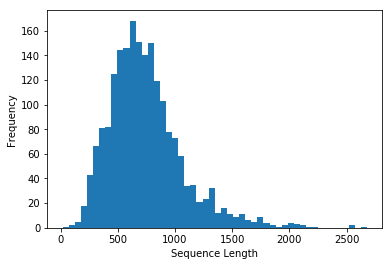

In [6]:
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

From the histogram as well as the average number of words per file, we can safely say that most reviews will fall under 750 words, which is the max sequence length value we will set. 

In [7]:
maxSeqLength = 750

Let's take a single file and transform it into our ids matrix. This is what the first line of one of the reviews looks like:

In [8]:
fname = positiveFiles[740] #Can use any valid index (not just 3)
print(fname)
with open(fname) as f:
    for lines in f:
        print(lines)
        break

txt_sentoken/pos/cv897_10837.txt
i must admit that i was a tad skeptical of " good will hunting " , based both on the previews and the first fifteen minutes of the film , in which the main character will hunting ( matt damon ) , an mit janitor in his early twenties , is discovered to be an einstein-level closet genius when he solves two extraordinarily difficult math problems overnight . 



Lets create a function for removing punctuation, parentheses, question marks, etc., and leave only alphanumeric characters.

In [9]:
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

Now, let's convert to to an ids matrix

In [10]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    lines=f.readlines()
    for line in lines:
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        #print(split)
        for word in split:
            if indexCounter < maxSeqLength:
                try:
                    firstFile[indexCounter] = wordsList.index(word)
                except ValueError:
                    firstFile[indexCounter] = 399999 #Vector for unknown words
            indexCounter = indexCounter + 1
firstFile[600:], print("shape:", firstFile.shape)

shape: (750,)


(array([     6,     42,     78,   2103,     88,      6,    853,   1650,
            43,  11228,    101,    138,     17,      7,  57044,  19980,
         11225,      3,    473,    417,   4311,      6,    637,  16574,
          1483,     17,     26,   1095,     96,   3722,  49733,   2663,
         25859,     14,   1140,    871,  18068,     83,   3779,   2241,
        201534,    319,     31,    558,   2054,      3, 201534,   3880,
          1388,     42,     15,     96,    647, 201534,   1247,     10,
            47, 399999,      5,  20001,   1003,    143,      4, 201534,
           380,      3,  16574,   1395,   1679,     64,     37,      4,
        201534,    853,     12,    219,     43,   4429,    151,   6297,
             4,   2933,    138,     29,  28687,   1751,   1945,    296,
           881,  23808,  17614,      5,     81,    414,     30,   9215,
           738,     41, 201398,    454,     37,    319,    133,   1569,
           143,     10,     48,    873,     84,   1120,    197, 

Now, let's do the same for each of our 2000 reviews in the Rotten Tomatoes dataset. 

Instead of computing the ids matrix, we can load in a pre-computed IDs matrix.

In [11]:
# ids = np.zeros((numFiles, maxSeqLength), dtype='int32')

# fileCounter = 0

# for pf in positiveFiles:
#     with open(pf, "r") as f:
#         indexCounter = 0
#         lines=f.readlines()
#         for line in lines:
#             cleanedLine = cleanSentences(line)
#             split = cleanedLine.split()
#             for word in split:
#                 try:
#                     ids[fileCounter][indexCounter] = wordsList.index(word)
#                 except ValueError:
#                     ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#                 print(fileCounter,indexCounter)
#                 indexCounter = indexCounter + 1
#                 if indexCounter >= maxSeqLength:
#                     break
#             if indexCounter >= maxSeqLength:
#                     break
#         fileCounter = fileCounter + 1

# for nf in negativeFiles:
#     with open(nf, "r") as f:
#         indexCounter = 0
#         lines=f.readlines()
#         for line in lines:
#             cleanedLine = cleanSentences(line)
#             split = cleanedLine.split()
#             for word in split:
#                 try:
#                     ids[fileCounter][indexCounter] = wordsList.index(word)
#                 except ValueError:
#                     ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#                 indexCounter = indexCounter + 1
#                 if indexCounter >= maxSeqLength:
#                     break
#             if indexCounter >= maxSeqLength:
#                     break
#         fileCounter = fileCounter + 1

# np.save('idsMatrix2', ids)

In [12]:
# load precomputed ids
ids = np.load('idsMatrix2.npy')

In [13]:
ids.shape

(2000, 750)

## 2 - Training

### The RNN Model

Now, we’re ready to start creating our Tensorflow graph. We’ll first need to define some hyperparameters, such as batch size, number of LSTM units, number of output classes, and number of training iterations. 

In [14]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 100000
numDimensions = 300

In [15]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Once we have our input data placeholder, we’re going to call the tf.nn.embedding_lookup() function in order to get our word vectors. 

In [16]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

We’re then going to call the tf.nn.rnn_cell.BasicLSTMCell function.  We’ll then wrap that LSTM cell in a dropout layer to help prevent the network from overfitting. Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input data into a function called tf.nn.dynamic_rnn. This function is in charge of unrolling the whole network and creating a pathway for the data to flow through the RNN graph.

In [17]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

The first output of the dynamic RNN function can be thought of as the last hidden state vector. This vector will be reshaped and then multiplied by a final weight matrix and a bias term to obtain the final output values.

In [18]:
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))

prediction = (tf.matmul(last, weight) + bias)

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

In [19]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

We’ll define a standard cross entropy loss with a softmax layer put on top of the final prediction values. For the optimizer, we’ll use Adam and the default learning rate of .001. 

In [20]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Tensorboard to visualize the loss and accuracy values:

In [21]:
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
with tf.Session() as sess:
    writer = tf.summary.FileWriter(logdir, sess.graph)

Helper functions to get the training and testing batches. Training is done on 4/5 of the dataset and testing on 1/5.

In [22]:
def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0):
            num = randint(1,979)
            labels.append([1,0])
        else:
            num = randint(1019,1999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(979,1019)
        if (num <= 999):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

We train the model by loading in a batch of reviews and their associated labels. We compute the optimizer since that is the component that minimizes our loss function.

Instead of training the network we can also load in a pretrained model.

In [23]:
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
# sess.run(tf.global_variables_initializer())

# for i in range(iterations):
#    #Next Batch of reviews
#    nextBatch, nextBatchLabels = getTrainBatch();
#    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
#    #Write summary to Tensorboard
#    if (i % 50 == 0):
#        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
#        writer.add_summary(summary, i)

#    #Save the network every 10,000 training iterations
#    if (i % 10000 == 0 and i != 0):
#        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
#        print("saved to %s" % save_path)
# writer.close()

Loading the Pretrained Model:

In [24]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

saver = tf.train.import_meta_graph('models/pretrained_lstm.ckpt-60000.meta')
saver.restore(sess,tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-60000


To see the graph definition:

In [25]:
graph = tf.get_default_graph()
print([op.name for op in graph.get_operations()][1100:1150])

['gradients/rnn/while/basic_lstm_cell/BiasAdd_grad/tuple/control_dependency', 'gradients/rnn/while/basic_lstm_cell/BiasAdd_grad/tuple/control_dependency_1', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul/Enter', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul_1', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul_1/f_acc', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul_1/Enter', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul_1/StackPushV2', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul_1/StackPopV2', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/MatMul_1/StackPopV2/Enter', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/tuple/group_deps', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/tuple/control_dependency', 'gradients/rnn/while/basic_lstm_cell/MatMul_grad/tuple/control_dependency_1', 'gradients/rnn/while/basic_lstm_cell/BiasAdd/Enter_grad/b_acc', 'gradients/rnn/while/ba

## 3 - Testing

We can use the getTestBatch() function to generate test batches to test our model like so:

In [26]:
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 50.0
Accuracy for this batch: 58.3333313465
Accuracy for this batch: 54.1666686535
Accuracy for this batch: 54.1666686535
Accuracy for this batch: 58.3333313465
Accuracy for this batch: 66.6666686535
Accuracy for this batch: 54.1666686535
Accuracy for this batch: 41.6666656733
Accuracy for this batch: 50.0
Accuracy for this batch: 54.1666686535


We can also provide our own reviews / sentences and see how our model classifies its sentiment! A few helper functions to clean up the provided text:

In [27]:
def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def getSentenceMatrix(sentence):
    arr = np.zeros([batchSize, maxSeqLength])
    sentenceMatrix = np.zeros([batchSize,maxSeqLength], dtype='int32')
    cleanedSentence = cleanSentences(sentence)
    split = cleanedSentence.split()
    for indexCounter,word in enumerate(split):
        try:
            sentenceMatrix[0,indexCounter] = wordsList.index(word)
        except ValueError:
            sentenceMatrix[0,indexCounter] = 399999 #Vector for unkown words
    return sentenceMatrix

We can provide our own input text like so:

In [28]:
inputText = "Worst movie of all times. Bad screenplay, pathetic acting"

Or we can provide an input text from another dataset. This one is a negative review from the [IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

In [39]:
# inputText = '''Nine minutes of psychedelic, pulsating, often symmetric abstract images, 
# are enough to drive anyone crazy. I did spot a full-frame eye at the start, 
# and later some birds silhouetted against other colors. It was just not my cup of tea. 
# It's about 8 minutes too long.'''

In [40]:
inputMatrix = getSentenceMatrix(inputText)

In [41]:
predictedSentiment = sess.run(prediction, {input_data: inputMatrix})[0]

if (predictedSentiment[0] > predictedSentiment[1]):
    print("Positive Sentiment")
else:
    print("Negative Sentiment")

Negative Sentiment


Now let's try a positive review:

In [32]:
secondInputText = "Interstellar is the best movie I have ever seen. The sotryline is gripping and intense"

Or we can input one from the IMDB dataset

In [36]:
# secondInputText = '''When I was a kid I watched this many times over, 
# and I remember whistling the "Happy Cat" song quite often. 
# All the songs are great, and actually meorable, unlike many children's musicals, 
# where the songs are just stuck in for no real reason. The scenes and costumes are lavish, 
# and the acting is very well-done, which isn't surprising, considering the cast. 
# I'd recommend this film to children and parents alike, who love magic and fairytales. 
# And it actually IS a movie you can watch together, as it won't drive adults up the wall.'''

In [37]:
secondInputMatrix = getSentenceMatrix(secondInputText)

In [38]:
predictedSentiment = sess.run(prediction, {input_data: secondInputMatrix})[0]
if (predictedSentiment[0] > predictedSentiment[1]):
    print("Positive Sentiment")
else:
    print("Negative Sentiment")

Positive Sentiment
